## Exercise 1– BABY NAMES BY STATE and YEAR

In [1]:
# Import the libraries needed
import pandas as pd
import matplotlib.pyplot as plt

# Import a file with abbreviations of the states for reference
with open("states.txt", "r") as file:
    states = [line.strip().replace('"', '').split(",") for line in file]
states = [state[1] for state in states[1:]]

In [2]:
class BabyNames:
    """A class that demonstrates the patterns in baby names by state over the years.
    """
    
    # Define the column names of dataframes 
    columns = ["state", "gender","year", "name", "count"]
   
    def __init__(self, path):
        """Initiate instances by reading from files and concatenating them into dataframes
        """
        
        babyname_state = []
        
        # Read the data from files
        for state in states:
            babyname = pd.read_csv(path + str(state)+".TXT", names = BabyNames.columns)
            babyname_state.append(babyname)
            
        # Convert list into dataframe
        self.df = pd.concat(babyname_state,ignore_index = True)
    
   
    def Count(self, state=None, year=None):
        """Count the total number of births at a certain state and year. Empty state means all, same for year.
        """
        
        if state == None and year == None:
            return self.df.sum()["count"]
        if state == None:
            return self.df[self.df["year"] == year].sum()["count"]
        if year == None:
            return self.df[self.df["state"] == state].sum()["count"]
        return self.df[(self.df["year"] == year) & (self.df["state"] == state)].sum()["count"]
    
    def Top10BabyNames(self, state=None, year=None):
        """Return a dataframe showing the top 10 baby names for a certain state and year. Empty state means all, same for year.
        """
        
        # Select the rows corresponding to state and year
        if state == None and year == None:
            df_state_year = self.df
        elif state == None:
            df_state_year = self.df[self.df["year"] == year]
        elif year == None:
            df_state_year = self.df[self.df["state"] == state]
        else:
            df_state_year = self.df[(self.df["year"] == year) & (self.df["state"] == state)]
        
        # Calculate the total number of births for each name used by different genders 
        df_sum = df_state_year.groupby(["gender", "name"]).sum()["count"].to_frame().reset_index()
        
        # Sort the values based on number of births and assign a rank
        df_rank = df_sum.assign(rank = df_sum.groupby("gender")["count"].rank("first", ascending = False)).\
                                sort_values("rank").head(20).pivot(index = "rank", columns = "gender", values = "name").reset_index()
        
        # Rename the columns 
        df_rank.columns = ["Rank", "Female", "Male"]
        return df_rank
    
    def ChangeOfPopularity(self, fromYear, toYear, top):
        """Print baby names(male or female) showing change in popularity as follows:
            i.Names that increased most in popularity.
            ii.Names that decreased most in popularity.
            iii.The most popular names that had the same popularity  
        """
        
        # Select the data we need from the whole table and reshape it
        df_change = self.df[(self.df["year"] == fromYear) | (self.df["year"] == toYear)].groupby(["name","year"]).\
                        sum()["count"].to_frame().reset_index().pivot(index = "name", columns = "year", values = "count").fillna(0)
        
        # Calculate the difference of count bwtween toYear and fromYear
        df_change["change"] = df_change[toYear] - df_change[fromYear]
        
        # Print the results
        print("Top" + str(top) + "names that increased in popularity:")
        print(df_change.sort_values("change", ascending = False).head(top))
        print("Top" + str(top) + "names that decreased in popularity:")
        print(df_change.sort_values("change").head(top))
        print("Top" + str(top) + "names having the same popularity:")
        print(df_change[df_change["change"] == 0].sort_values(fromYear, ascending = False).head(top))

    def Top5NamesPerYear(self, year, sex=None):
        """Return a dataframe showing the top 5 names for the corresponding year and sex. 
        """
        
        # Select the data we need from the whole dataframe
        if sex == None:
            df_year = self.df[self.df["year"] == year]
        else:
            df_year = self.df[(self.df["year"] == year) & (self.df["gender"] == sex)]
            
        # Select the top 5 names for each state
        df_top5 = df_year.sort_values("count", ascending = False).groupby("state").head(5)
        df_top5 = df_top5.assign(rank = df_top5.groupby("state")["count"].rank(method = "first",ascending = False)).\
                                    pivot(index = "state", columns = "rank", values = ["name", "count"]).stack(0).unstack()
        df_top5 = df_top5[[(1.0, "name"),(1.0, "count"),(2.0, "name"),(2.0, "count"),\
                                (3.0, "name"),(3.0, "count"),(4.0, "name"),(4.0, "count"),\
                                (5.0, "name"),(5.0, "count")]]
        return df_top5

        

    def NamePopularityPlot(self, name, yearRange, state, sex):
        """Create a plot that shows the name popularity changes over the year. 
        Popularity is based on the proportional use of the name within a state and year.
        """
        
        # Select the data of the state and years we need
        df_state = self.df[self.df["state"] == state]
        proportion_list = []
        for year in yearRange:
            df_state_year = df_state[df_state["year"] == year]
            total = df_state_year.sum()["count"]
            popularity_count = df_state_year[(df_state_year["name"] == name) & (df_state_year["gender"] == sex)]["count"].values
            
            # If no corresponding count for a certain year and state, then the popularity is 0
            if len(popularity_count) == 0:
                popularity = 0
            else:
                popularity = popularity_count[0]
            proportion_list.append(popularity/total)
            
        # Plot the changes 
        plt.plot(yearRange, proportion_list)
        
    def NameFlip(self, n=10):
        """A flip is defined as a name used to be mostly used by a certain gender and then became mostly used by the 
        other gender in the following year. The function returns the baby names that flip most often during the years.
        """
        # Calculate the number of births based on name, year and gender 
        df_flip = self.df.groupby(["name","year", "gender"]).sum()["count"].to_frame().unstack("gender")
        df_flip.columns = df_flip.columns.droplevel()
        
        # Create a column showing the dominant gender for a name
        df_flip["gen_dom"] = ["F" if female else "M" for female in df_flip["F"] > df_flip["M"]]
        df_flip["gen_dom_shift"] = df_flip.groupby("name")["gen_dom"].shift().fillna(df_flip["gen_dom"])
        
        # Calculate the total number of flips for a name 
        df_flip["flip"] = [1 if flip else 0 for flip in df_flip["gen_dom"] != df_flip["gen_dom_shift"]]
        return df_flip.groupby("name").sum()["flip"].sort_values(ascending = False).head(10)
        
        

In [3]:
baby = BabyNames("")

In [4]:
baby.Count(state='NY',year=2000)

214866

In [5]:
baby.Top10BabyNames(year=2000)

,Rank,Female,Male
0,1.0,Emily,Jacob
1,2.0,Hannah,Michael
2,3.0,Madison,Matthew
3,4.0,Ashley,Joshua
4,5.0,Sarah,Christopher
5,6.0,Alexis,Nicholas
6,7.0,Samantha,Andrew
7,8.0,Jessica,Joseph
8,9.0,Elizabeth,Daniel
9,10.0,Taylor,Tyler


In [6]:
baby.ChangeOfPopularity(2015,2016,10)

Top10names that increased in popularity:
year          2015     2016  change
name                               
Adeline     2404.0   4115.0  1711.0
Charlotte  11398.0  13090.0  1692.0
Mateo       5004.0   6538.0  1534.0
Oliver     11655.0  13037.0  1382.0
Bryson      3098.0   4343.0  1245.0
Lincoln     6088.0   7213.0  1125.0
Riley       7814.0   8840.0  1026.0
Adaline      871.0   1859.0   988.0
Benjamin   13700.0  14641.0   941.0
Amelia      9861.0  10774.0   913.0
Top10names that decreased in popularity:
year          2015     2016  change
name                               
Logan      13718.0  12072.0 -1646.0
Jayden     11949.0  10463.0 -1486.0
Jacob      15954.0  14510.0 -1444.0
Mason      16679.0  15293.0 -1386.0
Sophia     17417.0  16128.0 -1289.0
Alexa       6033.0   4759.0 -1274.0
Ethan      15077.0  13819.0 -1258.0
Aiden      13479.0  12236.0 -1243.0
Alexander  14547.0  13408.0 -1139.0
Madison    10130.0   9039.0 -1091.0
Top10names having the same popularity:
year        201

In [7]:
baby.Top5NamesPerYear(2015,'F')

rank        1.0              2.0              3.0              4.0        \
           name count       name count       name count       name count   
state                                                                      
AK       Olivia    56       Emma    49     Aurora    46        Ava    41   
AL          Ava   298       Emma   287     Olivia   260     Harper   214   
AR         Emma   214     Olivia   171        Ava   169   Isabella   135   
AZ       Sophia   475        Mia   465       Emma   452     Olivia   420   
CA       Sophia  2956        Mia  2864       Emma  2722     Olivia  2530   
CO         Emma   355     Olivia   348        Mia   254     Evelyn   251   
CT       Sophia   217       Emma   203     Olivia   202   Isabella   186   
DC      Genesis    50  Charlotte    47        Ava    47      Sofia    45   
DE          Ava    69     Olivia    59     Sophia    57    Abigail    48   
FL     Isabella  1382       Emma  1225     Sophia  1179     Olivia  1157   
GA          Ava   634     Olivia   563       Emma   541    Madison   444   
HI          Mia    73       Emma    67     Olivia    62       Aria    59   
IA         Emma   200     Olivia   192     Harper   183     Evelyn   143   
ID       Olivia   116       Emma   114     Evelyn    74        Ava    72   
IL       Olivia   815       Emma   811     Sophia   735        Mia   668   
IN         Emma   435     Olivia   413        Ava   382     Harper   335   
KS         Emma   215     Olivia   199        Ava   161     Harper   161   
KY         Emma   308     Olivia   272        Ava   254     Harper   230   
LA          Ava   323       Emma   294     Olivia   256   Isabella   193   
MA       Olivia   430       Emma   402     Sophia   373   Isabella   351   
MD       Olivia   321        Ava   308     Sophia   307       Emma   278   
ME         Emma    75     Olivia    68     Amelia    65    Abigail    55   
MI       Olivia   604        Ava   572       Emma   501     Sophia   420   
MN       Olivia   378       Emma   323     Evelyn   272        Ava   267   
MO         Emma   396     Olivia   379        Ava   326     Harper   299   
MS          Ava   214       Emma   166     Olivia   141    Madison   120   
MT         Emma    69     Olivia    58     Harper    53        Ava    47   
NC          Ava   624       Emma   583     Olivia   565   Isabella   432   
ND          Ava    71       Emma    70     Olivia    64     Harper    59   
NE       Olivia   121       Emma   120     Harper   117  Charlotte   109   
NH       Olivia    91  Charlotte    87       Emma    82     Sophia    66   
NJ         Emma   532     Sophia   518   Isabella   518     Olivia   504   
NM          Mia   122     Sophia   113   Isabella   103        Ava    97   
NV       Sophia   190     Olivia   174        Mia   170       Emma   159   
NY       Olivia  1297       Emma  1258     Sophia  1122   Isabella  1069   
OH         Emma   722        Ava   713     Olivia   693     Sophia   542   
OK         Emma   270     Olivia   244        Ava   189   Isabella   176   
OR         Emma   234     Olivia   221     Sophia   181    Abigail   170   
PA       Olivia   784       Emma   766        Ava   723     Sophia   595   
RI       Olivia    83       Emma    77     Sophia    74        Ava    64   
SC          Ava   281     Olivia   238       Emma   226    Madison   207   
SD       Harper    59       Emma    58     Olivia    51        Ava    46   
TN         Emma   477        Ava   415     Olivia   413     Harper   298   
TX         Emma  2205     Sophia  2178        Mia  2041   Isabella  1866   
UT         Emma   285     Olivia   281  Charlotte   192     Evelyn   160   
VA         Emma   466     Olivia   461        Ava   458  Charlotte   404   
VT         Emma    33        Ava    31     Harper    26  Charlotte    25   
WA       Olivia   478       Emma   422     Sophia   353        Ava   306   
WI         Emma   352     Olivia   348     Evelyn   262        Ava   262   
WV         Emma   143        Ava   109     Olivi

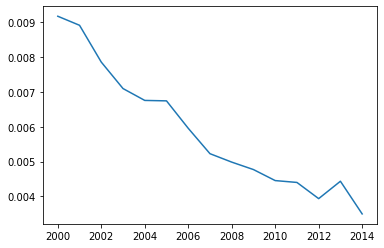

In [8]:
baby.NamePopularityPlot("Matthew", range(2000, 2015), "IL", "M")

In [9]:
baby.NameFlip()

name
Luz           42
Alma          42
Pilar         36
Lou           34
Rosa          32
Inez          32
Evelyn        30
Concepcion    30
Lorenza       30
Natividad     28
Name: flip, dtype: int64

## Exercise 2 - Pandas

In [10]:
# Import libraries needed
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

In [11]:
# Connect to mysql
cnx = pymysql.connect(user='root', \
      password='', \
      host= 'localhost', \
      port=3306, \
      db='world', \
      autocommit=True)

# Read the country table
df_country = pd.read_sql_query("select * from Country", con=cnx)

#### 1.  Find the top 10 countries which have the largest population and have a  population greater than 50000000. Rank them descendingly based on population. 
select *
<br>from country
<br>where population > 50000000
<br>order by population DESC limit 10

#### sql solution

In [12]:
df_p1_sql = pd.read_sql_query('select * from country where population > 50000000 order by population DESC limit 10',\
                              con=cnx)
df_p1_sql

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
2,USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
4,BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754,NG


#### pandas solution

In [13]:
df_p1_pandas = df_country[df_country["Population"] > 50000000].sort_values(by = "Population", ascending = False).\
                                                                            head(10).reset_index(drop = True)
df_p1_pandas

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
2,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
4,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


#### 2. Calculate the number of countries and the total population for each continent and rank them in alphabet order of continents.
select Continent, count(*) As Number_Countries, sum(population) As Population
<br>from country
<br>where population > 0
<br>group by Continent
<br>order by 1 ASC

#### sql solution

In [14]:
df_p2_sql = pd.read_sql_query('select Continent, count(*) As Number_Countries, sum(population) As Population \
                                from country \
                                where population > 0 \
                                group by Continent \
                                order by 1 ASC', con = cnx)
df_p2_sql

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


#### pandas solution

In [15]:
df_p2_pandas = df_country[df_country["Population"] > 0].groupby("Continent").agg({"Name": "size","Population": "sum"}).\
                                    rename(columns = {"Name": "Name_Countries"}).sort_values("Continent").reset_index()
df_p2_pandas

,Continent,Name_Countries,Population
0,Africa,57,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,27,30401150
5,South America,14,345780000


#### 3. Find the top 10 cities in the United States which have the largest population
select city.Name As City, city.population
<br>from city
<br>inner join country ON city.CountryCode = country.code
<br>where country.code = 'USA'
<br>order by city.population DESC limit 10

In [16]:
df_city = pd.read_sql_query('select * from city', con=cnx,index_col='ID')

In [17]:
df_p3_sql = pd.read_sql_query('select city.Name As City, city.population \
                                from city \
                                inner join country ON city.CountryCode = country.code \
                                where country.code = "USA" \
                                order by city.population DESC limit 10', con = cnx)
df_p3_sql

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


In [18]:
df_p3_pandas = df_city.merge(df_country.query("Code == 'USA'"), left_on = "CountryCode", right_on = "Code", \
                            how = "inner")[["Name_x","Population_x"]].rename(columns = {"Name_x":"City",\
                            "Population_x": "population"}).sort_values("population",ascending = False).head(10)
df_p3_pandas

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


#### 4. Find the top 10 countries which have the most number of people speaking the official language of the country
select country.Name, Language, (Percentage * population) / 100
<br>from countrylanguage
<br>inner join country on countrylanguage.CountryCode = country.code
<br>where IsOfficial = True
<br>order by 3 DESC limit 10

In [19]:
df_countrylanguage = pd.read_sql_query('select * from countrylanguage', con=cnx)

In [20]:
df_p4_sql = pd.read_sql_query('select country.Name, Language, (Percentage * population) / 100 \
                                from countrylanguage \
                                inner join country on countrylanguage.CountryCode = country.code \
                                where IsOfficial = True \
                                order by 3 DESC limit 10',con=cnx)
df_p4_sql

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044512e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


In [21]:
df_p4_pandas = pd.merge(df_countrylanguage, df_country, left_on = "CountryCode", right_on = "Code", how = "inner").\
                        query("IsOfficial == 'T'").assign(pop = lambda x: x["Percentage"] * x["Population"]/100).\
                        rename(columns = {"pop": "(Percentage * population) / 100"})[["Name", "Language", \
                        "(Percentage * population) / 100"]].sort_values("(Percentage * population) / 100",\
                        ascending = False).head(10).reset_index(drop = True)
df_p4_pandas

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


#### 5. Find the top 5 languages used by most number of people 
select Language, sum((Percentage * population) / 100)
<br>from countrylanguage
<br>inner join country ON countrylanguage.CountryCode = country.code
<br>group by Language
<br>order by 2 desc limit 5

#### sql solution

In [22]:
df_p5_sql = pd.read_sql_query('select Language, sum((Percentage * population) / 100) \
                                from countrylanguage \
                                inner join country ON countrylanguage.CountryCode = country.code \
                                group by Language \
                                order by 2 desc limit 5', con=cnx)
df_p5_sql

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


#### pandas solution

In [23]:
df_p5_pandas = pd.merge(df_countrylanguage, df_country, left_on = "CountryCode", right_on = "Code", how = "inner").\
                        assign(pop = lambda x: x["Percentage"] * x["Population"]/100).groupby("Language").\
                        agg({"pop":"sum"}).sort_values("pop", ascending = False).head(5).\
                        rename(columns = {"pop":"sum((Percentage * population) / 100)"}).reset_index()
df_p5_pandas

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08
